<a href="https://colab.research.google.com/github/sukkyun2/big-data-visualization-and-analysis/blob/main/09.VPC%20Flow%20Log.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VPC Flow Log를 이용한 이상 트래픽 탐지

> 빅데이터분석시각화 Final Project

## Loading Libraries

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
import os
import gzip
import ipaddress
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import warnings

## Load Dataset

In [ ]:
github_repo_url='https://github.com/sukkyun2/big-data-visualization-and-analysis.git'

In [ ]:
dataset_path='big-data-visualization-and-analysis/dataset'

In [ ]:
!git clone $github_repo_url

Cloning into 'big-data-visualization-and-analysis'...
remote: Enumerating objects: 1379, done.
remote: Counting objects: 100% (1379/1379), done.
remote: Compressing objects: 100% (1375/1375), done.
remote: Total 1379 (delta 15), reused 1349 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (1379/1379), 1.72 MiB | 10.77 MiB/s, done.
Resolving deltas: 100% (15/15), done.


수집한 데이터 셋은 아래와 같은 구조

```
├── 16
│   ├── 533267253556_vpcflowlogs_ap-northeast-2_fl-0282c7ec20b408a58_20241216T0815Z_532515b6.log.gz
│   │   └── 533267253556_vpcflowlogs_ap-northeast-2_fl-0282c7ec20b408a58_20241216T0815Z_532515b6.log
│   ├── 533267253556_vpcflowlogs_ap-northeast-2_fl-0282c7ec20b408a58_20241216T0820Z_533515b6.log.gz
│   │   └── 533267253556_vpcflowlogs_ap-northeast-2_fl-0282c7ec20b408a58_20241216T0820Z_533515b6.log
│
├── 17
```

이러한 구조를 하나의 파일(output.log)로 합치기 위한 처리 과정

In [ ]:
output_file = 'output.log'
base_directory = dataset_path

with open(output_file, 'wb') as output_f:
    header = b"version account-id interface-id srcaddr dstaddr srcport dstport protocol packets bytes start end action log-status\n"
    output_f.write(header)

    # 디렉토리 반복
    for sub_dir in os.listdir(base_directory):
        sub_dir_path = os.path.join(base_directory, sub_dir)

        if os.path.isdir(sub_dir_path):
            # 각 디렉토리 내의 .gz 파일을 찾고 처리
            for gz_file in os.listdir(sub_dir_path):
                if gz_file.endswith('.gz'):
                    gz_file_path = os.path.join(sub_dir_path, gz_file)

                    # .gz 파일을 열고 내부의 .log 파일 읽기
                    with gzip.open(gz_file_path, 'rb') as f:
                        log_content = f.read().decode('utf-8').splitlines()

                        # 첫 번째 줄(헤더)은 제외하고 데이터만 덧붙이기
                        if len(log_content) > 1:
                            data_to_write = "\n".join(log_content[1:]).encode('utf-8')
                            output_f.write(data_to_write)
                            output_f.write("\n".encode('utf-8'))

In [ ]:
!head -n 10 output.log

version account-id interface-id srcaddr dstaddr srcport dstport protocol packets bytes start end action log-status
2 533267253556 eni-0a43805c93ed8187a 89.248.165.97 172.31.12.32 47891 58657 6 1 44 1734551369 1734551420 REJECT OK
2 533267253556 eni-0a43805c93ed8187a 89.248.163.142 172.31.12.32 48000 49821 6 1 44 1734551369 1734551420 REJECT OK
2 533267253556 eni-0a43805c93ed8187a 2.57.122.195 172.31.12.32 39336 22 6 3 180 1734551369 1734551420 ACCEPT OK
2 533267253556 eni-0a43805c93ed8187a 154.213.184.66 172.31.12.32 38038 3716 6 1 52 1734551369 1734551420 REJECT OK
2 533267253556 eni-0a43805c93ed8187a 79.110.62.92 172.31.12.32 45489 2108 6 1 40 1734551369 1734551420 REJECT OK
2 533267253556 eni-0a43805c93ed8187a 147.185.132.131 172.31.12.32 57326 47382 6 1 44 1734551369 1734551420 REJECT OK
2 533267253556 eni-0a43805c93ed8187a 206.168.35.76 172.31.12.32 17280 2052 6 1 60 1734551369 1734551420 REJECT OK
2 533267253556 eni-0a43805c93ed8187a 103.102.230.6 172.31.12.32 53905 8728 6 1 40 1

In [ ]:
df = pd.read_csv('output.log', sep='\s+', header=0)

In [ ]:
df.head()

,version,account-id,interface-id,srcaddr,dstaddr,srcport,dstport,protocol,packets,bytes,start,end,action,log-status
0,2,533267253556,eni-0a43805c93ed8187a,89.248.165.97,172.31.12.32,47891,58657,6,1,44,1734551369,1734551420,REJECT,OK
1,2,533267253556,eni-0a43805c93ed8187a,89.248.163.142,172.31.12.32,48000,49821,6,1,44,1734551369,1734551420,REJECT,OK
2,2,533267253556,eni-0a43805c93ed8187a,2.57.122.195,172.31.12.32,39336,22,6,3,180,1734551369,1734551420,ACCEPT,OK
3,2,533267253556,eni-0a43805c93ed8187a,154.213.184.66,172.31.12.32,38038,3716,6,1,52,1734551369,1734551420,REJECT,OK
4,2,533267253556,eni-0a43805c93ed8187a,79.110.62.92,172.31.12.32,45489,2108,6,1,40,1734551369,1734551420,REJECT,OK


## Preprocessing

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53664 entries, 0 to 53663
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   version       53664 non-null  int64 
 1   account-id    53664 non-null  int64 
 2   interface-id  53664 non-null  object
 3   srcaddr       53664 non-null  object
 4   dstaddr       53664 non-null  object
 5   srcport       53664 non-null  object
 6   dstport       53664 non-null  object
 7   protocol      53664 non-null  object
 8   packets       53664 non-null  object
 9   bytes         53664 non-null  object
 10  start         53664 non-null  int64 
 11  end           53664 non-null  int64 
 12  action        53664 non-null  object
 13  log-status    53664 non-null  object
dtypes: int64(4), object(10)
memory usage: 5.7+ MB


### Data Cleaning

#### Filtering LogStatus

- `log-status`가 `NODATA`인 row를 필터링
- NODATA란 집계기간동안 데이터가 기록되지 않았다는 뜻
- 따라서 이 값은 제거한다.
- [flow-logs-records-examples](https://docs.aws.amazon.com/vpc/latest/userguide/flow-logs-records-examples.html)

In [ ]:
df[df['log-status'] == 'NODATA']

,version,account-id,interface-id,srcaddr,dstaddr,srcport,dstport,protocol,packets,bytes,start,end,action,log-status
4973,2,533267253556,eni-0a43805c93ed8187a,-,-,-,-,-,-,-,1734549722,1734549739,-,NODATA
23815,2,533267253556,eni-0a43805c93ed8187a,-,-,-,-,-,-,-,1734365470,1734365506,-,NODATA


In [ ]:
df.drop(df[df['log-status'] == 'NODATA'].index, inplace=True)

#### Filtering Start With Private IP

- 해당 데이터는 인바운드 트래픽과 아웃바운드 트래픽이 합쳐져있다
- 인바운드 트래픽은 외부 IP에서 VPC로 들어오는 트래픽이고
- 아웃바운드 트래픽은 VPC에서 외부 IP로 응답하는 트래픽이다
- `srcaddr`이 `172.31.12.32`인 데이터는 아웃바운드 트래픽인데, 여기서는 인바운드 트래픽만을 이용하여 분석을 할 예정으로 제거한다.

In [ ]:
df[df['srcaddr']== '172.31.12.32'] # 제거 대상

,version,account-id,interface-id,srcaddr,dstaddr,srcport,dstport,protocol,packets,bytes,start,end,action,log-status
12,2,533267253556,eni-0a43805c93ed8187a,172.31.12.32,2.57.122.195,22,39336,6,8,480,1734551369,1734551420,ACCEPT,OK
39,2,533267253556,eni-0a43805c93ed8187a,172.31.12.32,185.191.126.213,80,44010,6,1,40,1734551483,1734551540,ACCEPT,OK
46,2,533267253556,eni-0a43805c93ed8187a,172.31.12.32,3.23.92.210,22,51526,6,8,1661,1734553943,1734554001,ACCEPT,OK
102,2,533267253556,eni-0a43805c93ed8187a,172.31.12.32,2.57.122.33,22,47921,6,6,264,1734505870,1734505904,ACCEPT,OK
125,2,533267253556,eni-0a43805c93ed8187a,172.31.12.32,172.236.141.233,22,58564,6,2,88,1734544341,1734544395,ACCEPT,OK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53627,2,533267253556,eni-0a43805c93ed8187a,172.31.12.32,205.210.31.208,80,56678,6,1,40,1734598318,1734598373,ACCEPT,OK
53630,2,533267253556,eni-0a43805c93ed8187a,172.31.12.32,3.94.91.31,43259,123,17,1,76,1734598318,1734598373,ACCEPT,OK
53643,2,533267253556,eni-0a43805c93ed8187a,172.31.12.32,170.187.163.90,443,34307,6,1,40,1734598386,1734598433,ACCEPT,OK
53651,2,533267253556,eni-0a43805c93ed8187a,172.31.12.32,195.3.223.52,80,47542,6,1,40,1734598438,1734598493,ACCEPT,OK


In [ ]:
df.drop(df[df['srcaddr'] == '172.31.12.32'].index, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49521 entries, 0 to 53663
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   version       49521 non-null  int64 
 1   account-id    49521 non-null  int64 
 2   interface-id  49521 non-null  object
 3   srcaddr       49521 non-null  object
 4   dstaddr       49521 non-null  object
 5   srcport       49521 non-null  object
 6   dstport       49521 non-null  object
 7   protocol      49521 non-null  object
 8   packets       49521 non-null  object
 9   bytes         49521 non-null  object
 10  start         49521 non-null  int64 
 11  end           49521 non-null  int64 
 12  action        49521 non-null  object
 13  log-status    49521 non-null  object
dtypes: int64(4), object(10)
memory usage: 5.7+ MB


#### Dropping unnecessary columns

- version, account-id, interface-id는 모든 row가 동일한 값을 가지고 있다.
- log-status는 `OK`, `NODATA`, `SKIPDATA`로 나뉘어지는데 OK가 아닌 값들을 위에서 필터링하였으므로 이 값도 항상 `OK`이다.
- 따라서 column을 drop한다

In [ ]:
df.drop(columns=['version', 'account-id', 'interface-id','log-status'], inplace=True)

### Data Transformation

#### Data encoding

- action column은 두 가지로 이루어진다.
- `ACCEPT`은 VPC를 통과했다는 의미이고 `REJECT`은 실패했다는 의미이다.
- `ACCPET`을 1로 `REJECT`을 0으로 변환한다

In [ ]:
df['action'] = df['action'].replace({'ACCEPT': 1, 'REJECT': 0})

<ipython-input-16-97297ff5fc82>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['action'] = df['action'].replace({'ACCEPT': 1, 'REJECT': 0})


#### Type Conversion

- 현재 `df.info()`를 확인하면 대부분이 object 형태이다 이를 number로 변경한다
- 혹시라도 처리할 수 없는 값이 있는경우 NaN으로 변경한다

In [ ]:
df['packets'] = pd.to_numeric(df['packets'], errors='coerce')
df['bytes'] = pd.to_numeric(df['bytes'], errors='coerce')
df['srcport'] = pd.to_numeric(df['srcport'], errors='coerce')
df['dstport'] = pd.to_numeric(df['dstport'], errors='coerce')
df['protocol'] = pd.to_numeric(df['protocol'], errors='coerce')

### Preprocessing Result

In [ ]:
df

,srcaddr,dstaddr,srcport,dstport,protocol,packets,bytes,start,end,action
0,89.248.165.97,172.31.12.32,47891,58657,6,1,44,1734551369,1734551420,0
1,89.248.163.142,172.31.12.32,48000,49821,6,1,44,1734551369,1734551420,0
2,2.57.122.195,172.31.12.32,39336,22,6,3,180,1734551369,1734551420,1
3,154.213.184.66,172.31.12.32,38038,3716,6,1,52,1734551369,1734551420,0
4,79.110.62.92,172.31.12.32,45489,2108,6,1,40,1734551369,1734551420,0
...,...,...,...,...,...,...,...,...,...,...
53659,173.230.150.73,172.31.12.32,34908,51005,6,1,44,1734598438,1734598493,0
53660,66.175.220.105,172.31.12.32,32942,12157,6,1,44,1734598438,1734598493,0
53661,78.128.113.130,172.31.12.32,8080,3377,6,1,40,1734598438,1734598493,0
53662,195.3.223.52,172.31.12.32,47542,80,6,1,40,1734598438,1734598493,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49521 entries, 0 to 53663
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   srcaddr   49521 non-null  object
 1   dstaddr   49521 non-null  object
 2   srcport   49521 non-null  int64 
 3   dstport   49521 non-null  int64 
 4   protocol  49521 non-null  int64 
 5   packets   49521 non-null  int64 
 6   bytes     49521 non-null  int64 
 7   start     49521 non-null  int64 
 8   end       49521 non-null  int64 
 9   action    49521 non-null  int64 
dtypes: int64(8), object(2)
memory usage: 4.2+ MB


## Exploratory Data Analysis

#### Top 10 Source IP by Count

- 가장 많은 접근을 한 상위 10개의 IP를 막대 그래프로 표현
- X축은 Source IP, Y축은 해당 IP로 기록된 인바운드 트래픽 개수
- `78.128.114.2`가 다른 IP보다 약 10배 많이 접근하였음

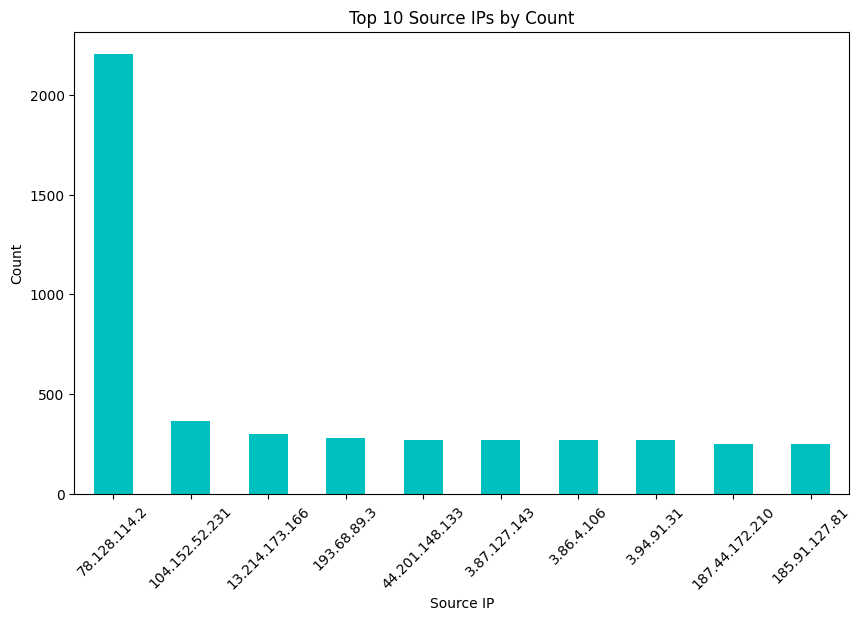

In [ ]:
src_ip_counts = df.groupby('srcaddr').size()
src_ip_counts = src_ip_counts.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
src_ip_counts.plot(kind='bar', color='c')
plt.title('Top 10 Source IPs by Count')
plt.xlabel('Source IP')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

#### Distribution of Accept and Reject Actions

- 모든 트래픽 중에서 VPC를 통과한 데이터(ACCPET), 통과하지 못한 데이터(REJECT)를 원형 그래프로 표현
- 약 90%이상의 데이터가 REJECT

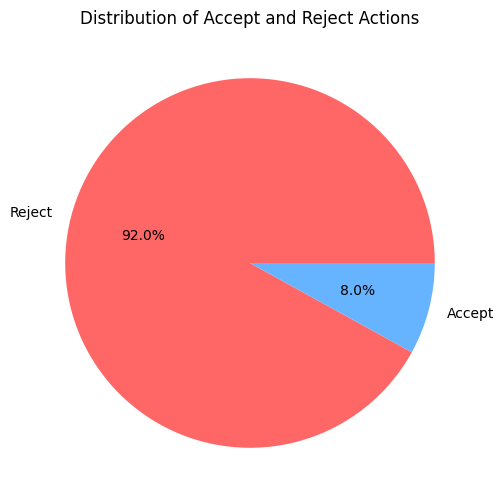

In [ ]:
action_counts = df['action'].value_counts()

plt.figure(figsize=(8, 6))
action_counts.plot(kind='pie', labels=['Reject', 'Accept'], autopct='%1.1f%%', colors=['#ff6666', '#66b3ff'])
plt.title('Distribution of Accept and Reject Actions')
plt.ylabel('')
plt.show()

#### Distribution of Packet Sizes

- 모든 트래픽에 대한 패킷 크기 분포를 확인
- X축은 패킷의 크기이고 Y축은 개수를 나타냄
- X축의 폭이 너무 커서 제대로 된 분포도가 안보여 byte값에 log를 적용
- 현재 X축이 4일때 가장 많은 분포가 있는데 이를 값으로 환산하면 약 53.6

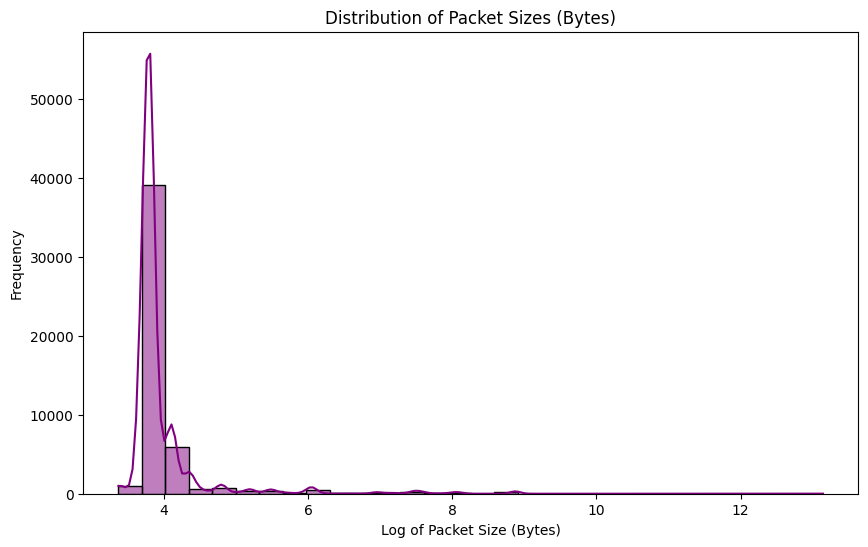

In [ ]:
# LOG 적용 이전 그래프
# plt.figure(figsize=(10, 6))
# sns.histplot(df['bytes'], bins=30, kde=True, color='purple')
# plt.title('Distribution of Packet Sizes (Bytes)')
# plt.xlabel('Packet Size (Bytes)')
# plt.ylabel('Frequency')
# plt.show()


plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(df['bytes']), bins=30, kde=True, color='purple')
plt.title('Distribution of Packet Sizes (Bytes)')
plt.xlabel('Log of Packet Size (Bytes)')
plt.ylabel('Frequency')
plt.show()

#### Scatter Plot for Multiple Source IPs

- 앞서 `Top 10 Source IP by Count` 3개의 IP를 뽑아 시간별 트래픽 산점도 표시
- X축은 트래픽 인입 시간, Y축은 지속시간으로 표현

<ipython-input-23-1af981e95238>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['start'] = pd.to_datetime(df_filtered['start'], unit='s')
<ipython-input-23-1af981e95238>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['end'] = pd.to_datetime(df_filtered['end'], unit='s')
<ipython-input-23-1af981e95238>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

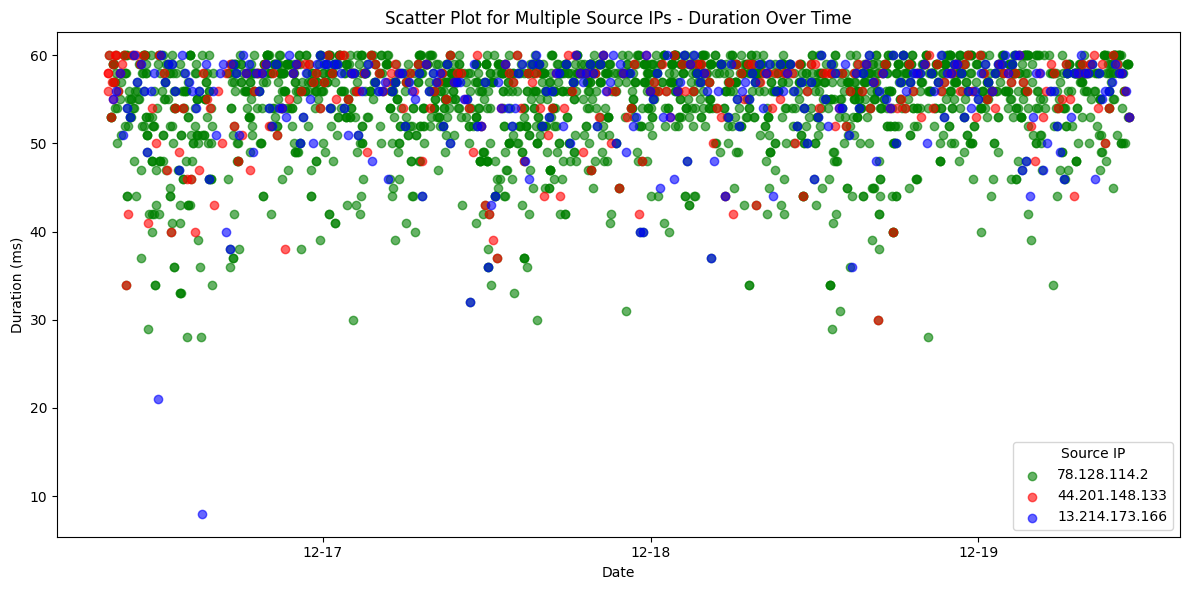

In [ ]:
target = ['78.128.114.2', '44.201.148.133', '13.214.173.166']

# 특정 IP 값에 대한 트래픽 데이터만 추출
df_filtered = df[df['srcaddr'].isin(target)]
df_filtered['start'] = pd.to_datetime(df_filtered['start'], unit='s')
df_filtered['end'] = pd.to_datetime(df_filtered['end'], unit='s')

# y축에 end-start 차이 계산
df_filtered['duration'] = (df_filtered['end'] - df_filtered['start']).dt.total_seconds()

# 각 IP에 대해 다른 색을 지정
color_map = {'78.128.114.2': 'green', '44.201.148.133': 'red', '13.214.173.166': 'blue'}

# 산점도 그리기
plt.figure(figsize=(12, 6))
for ip, color in color_map.items():
    ip_data = df_filtered[df_filtered['srcaddr'] == ip]
    plt.scatter(ip_data['start'], ip_data['duration'], color=color, alpha=0.6, label=ip)

plt.title('Scatter Plot for Multiple Source IPs - Duration Over Time')
plt.xlabel('Date')
plt.ylabel('Duration (ms)')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.legend(title='Source IP')

plt.tight_layout()
plt.show()

## Splitting into training and testing datasets

- VPC 트래픽 허용여부를 나타내는 `action`값을 기준으로 데이터 분할
- `train_test_split`을 이용하여 Train Data 와 Test Data 8:2로 분할

In [ ]:
def ip_to_int(ip):
    return int(ipaddress.IPv4Address(ip))

df['srcaddr'] = df['srcaddr'].apply(ip_to_int)
df['dstaddr'] = df['dstaddr'].apply(ip_to_int)

In [ ]:
X = df[['srcaddr', 'dstaddr', 'srcport', 'dstport', 'protocol', 'packets', 'bytes']]
y = df['action']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Training model

### SVM

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm_model = SVC(kernel='linear')
svm_model.fit(X_train_scaled, y_train)

SVC(kernel='linear')

### DecisionTree

In [ ]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

### RandomForest

In [ ]:
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## Checking Out Accuracy

In [ ]:
y_pred_svm = svm_model.predict(X_test_scaled)

print(f"SVM Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print("SVM Accuracy:\n", classification_report(y_test, y_pred_svm))

y_pred_dt = dt_model.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Decision Tree Classification Report:\n", classification_report(y_test, y_pred_dt))

y_pred_rf = rf_model.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

SVM Accuracy: 0.9254
SVM Accuracy:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      9070
           1       0.71      0.20      0.31       835

    accuracy                           0.93      9905
   macro avg       0.82      0.59      0.63      9905
weighted avg       0.91      0.93      0.91      9905

Decision Tree Accuracy: 1.0
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      9070
           1       1.00      1.00      1.00       835

    accuracy                           1.00      9905
   macro avg       1.00      1.00      1.00      9905
weighted avg       1.00      1.00      1.00      9905

Random Forest Accuracy: 0.9996971226653205
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      9070
           1       1.00      1.00      1.00       835


## Avoid Overfitting : Undersampling Dataset

In [ ]:
print("Train dataset 'action' distribution:")
print(y_train.value_counts())

print("\nTest dataset 'action' distribution:")
print(y_test.value_counts())

Train dataset 'action' distribution:
action
0    36478
1     3138
Name: count, dtype: int64

Test dataset 'action' distribution:
action
0    9070
1     835
Name: count, dtype: int64


In [ ]:
undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

print("Resampled Train dataset 'action' distribution:")
print(y_train_resampled.value_counts())

Resampled Train dataset 'action' distribution:
action
0    3138
1    3138
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [ ]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_resampled, y_train_resampled)

rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred_dt = dt_model.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Decision Tree Classification Report:\n", classification_report(y_test, y_pred_dt))

y_pred_rf = rf_model.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

Decision Tree Accuracy: 0.9982836951034831
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      9070
           1       0.98      1.00      0.99       835

    accuracy                           1.00      9905
   macro avg       0.99      1.00      0.99      9905
weighted avg       1.00      1.00      1.00      9905

Random Forest Accuracy: 0.9924280666330136
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      9070
           1       0.92      1.00      0.96       835

    accuracy                           0.99      9905
   macro avg       0.96      1.00      0.98      9905
weighted avg       0.99      0.99      0.99      9905



## Avoid Overfitting : Ensemble Learning

- Ensemble Learning 중 Stacking 방식을 사용

In [ ]:
base_learners = [
    ('svm', SVC(random_state=42)),
    ('decision-tree', DecisionTreeClassifier(random_state=42)),
    ('random-forest', RandomForestClassifier(random_state=42))
]

meta_learner = LogisticRegression()
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)

stacking_model.fit(X_train, y_train)

StackingClassifier(estimators=[('svm', SVC(random_state=42)),
                               ('decision-tree',
                                DecisionTreeClassifier(random_state=42)),
                               ('random-forest',
                                RandomForestClassifier(random_state=42))],
                   final_estimator=LogisticRegression())

In [ ]:
y_pred = stacking_model.predict(X_test)

print(f"Stacking Model Accuracy: {accuracy_score(y_test, y_pred)}")

Stacking Model Accuracy: 1.0


 ## Visualize accuracy

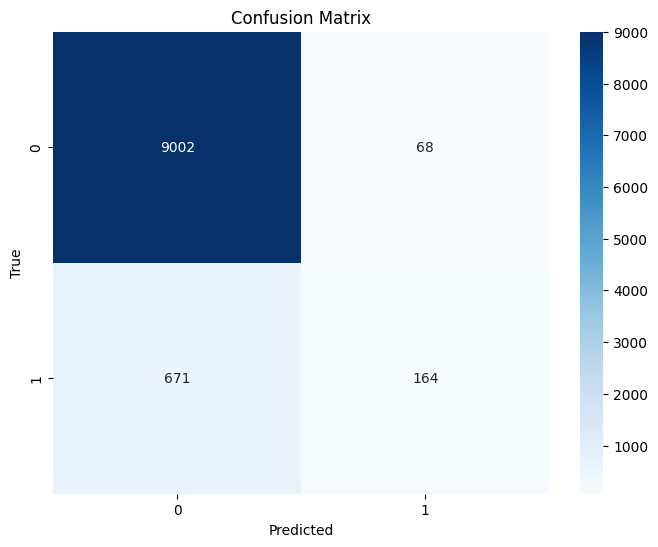

In [ ]:
cm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()